# Understand Intermediate Activations
Aim to understand the difference between 2D kinematic and density map information

In [1]:
# libraries
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.preprocessing import image

import numpy as np
import sys
import os
sys.path.append("../")

from utils import *

import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
%matplotlib inline

Using TensorFlow backend.


## Specify test data

In [2]:
# test file
test_num = '8'
pred_var = 'v'
map_type = 'density'

In [3]:
# Choosing parameters
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 2 if (pred_var == 'rv') or (pred_var == 'P_RPS') else 1
NUM_MAPS = 2 if map_type == 'joint' else 1
nmodel = 90000 if test_num == '9' else 10000

# parameters
path_data = "../../data/m1.dir_%s_%s/" % (test_num, map_type)
path_model = "../../gcloud_trained/m9.dir_e300_%s_%s/" % (map_type, pred_var)
n_mesh = 50
img_rows, img_cols = n_mesh, n_mesh
n_mesh2 = n_mesh * n_mesh - 1
n_mesh3 = n_mesh * n_mesh
input_shape = (img_rows, img_cols, NUM_MAPS)

In [4]:
# read test data and performing conversions
(x_test, y_test) = read_data(path_data, nmodel, NUM_CLASSES, pred_var)

reading data from: ../../data/m1.dir_8_density/


## Load model

In [5]:
# load model
try:
    model = load_model(path_model + "model.h5")
except:
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = input_shape))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'linear'))
    model.load_weights(path_model + "weights.h5")
    print(model.summary())
    print("Weights loaded")

In [6]:
# get intermediate layers (model)
layers = [layer.output for layer in model.layers] 
activation_model = Model(inputs = model.input, outputs = layers)

## Load images and inference (activation)

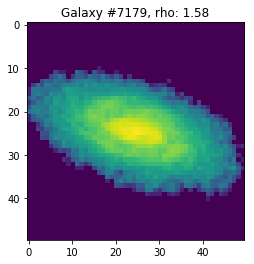

Activation dimensions
Layers: 8
(1, 48, 48, 32)


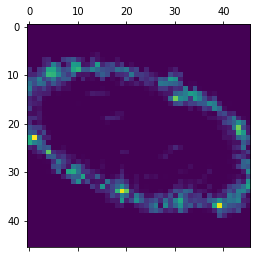

In [7]:
# feed image into activations model
index = 7179
plot_galaxy(x_test, y_test, index)
img_tensor = x_test[index]
img_tensor = np.expand_dims(img_tensor, axis = 0)

# inference with activation model
activations = activation_model.predict(img_tensor)
activations_firstLayer_array = np.array(activations[0])
print("Activation dimensions")
print("Layers: %i" % len(activations))
print(activations_firstLayer_array.shape)

# average of channels for given layer (activation outputs)
layer = 1
average = np.mean(activations[layer][0,:,:,:], axis = 2)
plt.matshow(average, cmap = 'viridis')
plt.show()

## Activation Insight
Looking through various activation layers for a given galaxy model we find that:
* Layer 1 is a 48 x 48 x 32 (where 32 is the channels) array resulting from the first convolution block applied the original image. 
* Layer 2 is 46 x 46 x 64 - we are doubling the number of channels with each conv2d block. 
* Layer 3 is 23 x 23 x 64 - maxPooling to reduce the size of the images further.
* Layer 4 is a flattened array (33856 units) from the previoud conv2d ouptut
* Layer 5 is a flattened array (128 units) from the output of the previous dense layer
* Layer 6 is (strangely) another dense layer (128 units).
* Layer 7 is the output prediction (1 or 2 units depending of prediction variable).

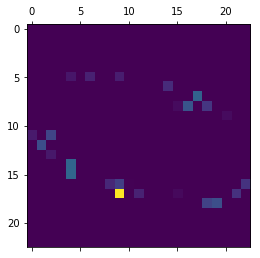

In [8]:
# investigate individual channels (activation outputs)
layer = 3
channel = 9
plt.matshow(activations[layer][0, :, :, channel], cmap = 'viridis')

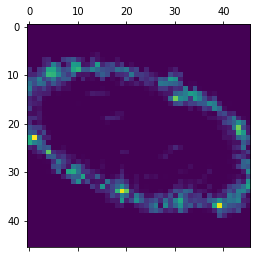

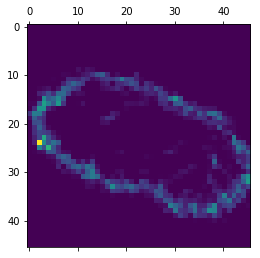

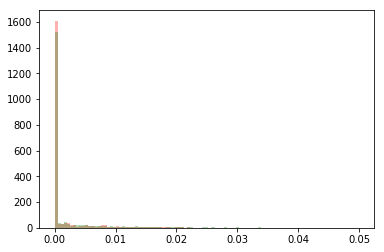

In [9]:
# comparing two plots
index1 = 7179
index2 = 9079
layer = 1

img_tensor1 = x_test[index1]
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor2 = x_test[index2]
img_tensor2 = np.expand_dims(img_tensor2, axis=0)

activations1 = activation_model.predict(img_tensor1)
activations2 = activation_model.predict(img_tensor2)

# average activation difference
average1 = np.mean(activations1[layer][0,:,:,:], axis = 2)
plt.matshow(average1, cmap = 'viridis')
plt.show()
average2 = np.mean(activations2[layer][0,:,:,:], axis = 2)
plt.matshow(average2, cmap = 'viridis')
plt.show()

# histogram of activation values
average_flat1 = average1.flatten()
average_flat2 = average2.flatten()
bins = np.linspace(0, 0.05, 100)
plt.hist(average_flat2, color = 'red', alpha = 0.3, bins = bins)
plt.hist(average_flat1, color = 'green', alpha = 0.3, bins = bins)
plt.show()

In [10]:
# multiple plots (assumes 1x3 plotting shape)
def plot_many_activations(X, y, indices, activation_model, layer, save):

    n = len(indices)

    # use TeX
    plt.rc('text', usetex = True)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 16)
    plt.figure(figsize = (12, 8))
    
    # subplot structure
    ax = [plt.subplot(1, 3, i+1) for i in range(n)] 
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ax[0].set_title(r'$\rho{}_{IGM}$ = ' + str(round(y[indices[0]][0],3)))
    ax[0].set_ylabel('2D Density', size = 'large')
    ax[1].set_title(r'$\rho{}_{IGM}$ = ' + str(round(y[indices[1]][0],3)))
    ax[2].set_title(r'$\rho{}_{IGM}$ = ' + str(round(y[indices[2]][0],3)))

    # activation outputs
    for i in range(n):
        ax = plt.subplot(1, 3, (i+1))
        index = indices[i]
        img = X[index]
        img_tensor = np.expand_dims(img, axis = 0)
        activations = activation_model.predict(img_tensor)
        average = np.mean(activations[layer][0, :, :, :], axis = 2)
        ax.imshow(average, vmin = 0, vmax = 0.05, cmap = 'viridis')
        
    if save:
        plt.savefig('FigX.png')

#     ax.colorbar(fraction = 0.05, pad = 0.04)
    plt.show()

/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


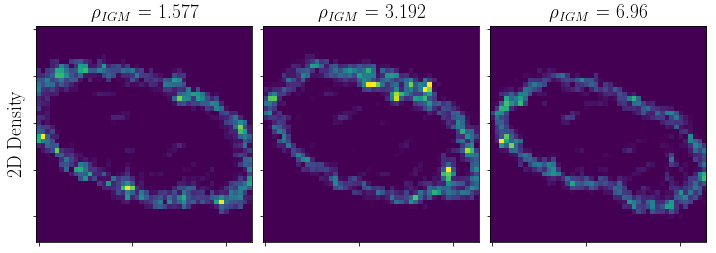

In [11]:
# plotting three sets of activations
indices = [7179, 8779, 9079]
plot_many_activations(x_test, y_test, indices, activation_model, 1, True)